# 기계학습 (60점)

### 비트코인 데이터

데이터 경로 : './data/bitcoin_mock.csv'

1분간격의 비트코인 가격에 대한 정보이다. 
- datetime: 1분 단위의 데이터
- open : 시작가
- high : 최고가
- low : 최저가
- close : 종가
- volume : 거래량

In [35]:
import pandas as pd
df =pd.read_csv('./data/bitcoin_mock.csv')
df.head()

,datetime,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894
4,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029


### 기계학습1
모든 데이터 행이 1분간격으로 존재하는지 확인하고 그렇지 않은 경우 누락된 시각의 행을 생성하고 컬럼들의 결측치를 적절히 생성하라.      
결측치가 존재한다면 결측치를 처리하라

In [40]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [46]:
df['diff'] = df['datetime'].diff(1).dt.seconds

In [134]:
# diff ==120 친구들을 필터하고 그 사이에 1분을 추가해서 빈 데이터를 넣는다
import datetime

lst = []
idx_lst = [0] + list(df[df['diff'] ==120].index)

for i, idx in enumerate(idx_lst[:-1]):
    
    target_df = df.iloc[idx_lst[i] : idx_lst[i+1]]
    empty_df = pd.DataFrame()
    next_one_min = (target_df['datetime'] + datetime.timedelta(minutes=1)).values[-1]
    empty_df['datetime'] = [next_one_min]
    concat_df = pd.concat([target_df,empty_df]).reset_index(drop=True)
    lst.append(concat_df)
    
lst.append(df.iloc[575932:])
total = pd.concat(lst).reset_index(drop=True).drop(columns =['diff'])
t = total.set_index('datetime').interpolate().reset_index()
total.iloc[:,1:] = total.iloc[:,1:].combine_first((total.iloc[:,1:].fillna(method='bfill') + total.iloc[:,1:].fillna(method='ffill'))/2)
t = total.copy()

In [153]:
# datetime 처음과 끝의 시간 데이터를 1분간격으로 새롭게 정의한 데이터프레임과 원본데이터를 merge

date_ranges = pd.DataFrame(pd.date_range(start ='2022-01-01 00:00:00' , end ='2023-03-02 19:12:00' ,freq='1T') ,columns =['datetime'])
total = pd.merge(date_ranges,df,how='outer').drop(columns =['diff'])

total = pd.concat(lst).reset_index(drop=True).drop(columns =['diff'])
t = total.set_index('datetime').interpolate().reset_index()
total.iloc[:,1:] = total.iloc[:,1:].combine_first((total.iloc[:,1:].fillna(method='bfill') + total.iloc[:,1:].fillna(method='ffill'))/2)
t = total.copy()

25개의 1분간격이 아닌 데이터가 존재했고 이를 1분간격의 빈 데이터를 생성하여 머지했다. 그리고 비어있는 결측치는 선형보간을 통해 채웠다.

### 기계학습2

t(분)까지 데이터가 확정된 시점에서 매도,매수를 판단하기 위한 알고리즘을 만들고 백테스팅을 진행하려한다.       
아래의 과정의 전처리를 시행하고 algorithm과 result 두 범주형 컬럼의 교차테이블을 출력하라

---
알고리즘
1. t(분)시점에서 close 값에 대한 t(분)시점의 5분,120분 이동평균값을 각각 't_5', 't_120'으로 컬럼으로 t-1(분)시점의 5분,120분 이동평균값을 각각 't-1_5', 't-1_120'으로 컬럼으로 만든다.
---
2. - t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120)보다 높고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 낮은 경우 : 'buy'   # 매수  
   - t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120 보다 낮고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 높은 경우 : 'sell'  # 매도
   - 그외 'stay'    
   
   위의 조건으로 buy(매수), sell(매도)를 판단하고 buy,sell,stay를 나타내는 새로운 컬럼 'algorithm'을 생성한다.
---         
3. t+10(분)의 open 값과 t(분)의 close값을 비교하여 새로운 컬럼 'result'를 만든다.
   - 여부가 'buy' 이고 t+10(분) open >= t(분) close : 'profit'
   - 여부가 'buy' 이고 t+10(분) open <  t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open >= t(분) close : 'loss'
   - 여부가 'sell' 이고 t+10(분) open <  t(분) close : 'profit'
   - 여부가 'stay' 이면 : 'stay' 
   
   위의 조건으로 컬럼값을 채운다

In [180]:
t['t_5'] = t['close'].rolling(5).mean()
t['t_120'] = t['close'].rolling(120).mean()

t['t-1_5'] = t['t_5'].shift(1)
t['t-1_120'] = t['t_120'].shift(1)

In [184]:
t = t.dropna().reset_index(drop=True)

In [194]:
def algo(x):
    t_5 = x['t_5']
    t_120 = x['t_120']
    t_1_5 = x['t-1_5']
    t_1_120 = x['t-1_120']
    
    
    if t_5 >t_120 and t_1_5 < t_1_120:
        return 'buy'
    
    elif t_5 < t_120 and t_1_5 > t_1_120:
        return 'sell'
    
    else:
        return 'stay'
    
t['algorithm'] = t[['t_5','t-1_5','t_120','t-1_120']].apply(algo,axis=1)

t['t+10'] = t['open'].shift(-10)




In [197]:

def result_filter(x):
    
    t_close = x['close']
    t_10_open = x['t+10']
    t_algorithm = x['algorithm']
    
    if t_algorithm =='stay':
        return 'stay'
    
    elif t_algorithm =='buy':
        if t_10_open >= t_close:
            return 'profit'
        
        else:
            return 'loss'
        
    elif t_algorithm =='sell':
        if t_10_open >= t_close:
            return 'loss'
        
        else:
            return 'profit'
    
t['result'] = t[['close','algorithm','t+10']].apply(result_filter,axis=1)

In [199]:
t = t.dropna(axis=1)

In [201]:
pd.crosstab(t.algorithm,t.result)

result,loss,profit,stay
algorithm,,,
buy,3756,3563,0
sell,3793,3526,0
stay,0,0,598395


### 기계학습3     
위에서 전처리한 데이터에 대해 아래 조건으로 그래프를 출력하라
1. 2022-01-01 08:00:00 ~ 2022-01-01 15:00:00 시간대의 close값의 선형 그래프
2. 위 시간대에 대해 algorithm 컬럼이 buy일 경우 빨간 수직선, sell일 경우 파란 수직선

<img src="./data/1.png" height='300' width='1200' style="float: left; margin-right: 10px;">

In [203]:
t.head()

,datetime,open,high,low,close,volume,t_5,t_120,t-1_5,t-1_120,algorithm,result
0,2022-01-01 02:00:00,46778.14,46813.16,46769.95,46804.69,13.51174,46785.106,46626.245083,46780.948,46621.622667,stay,stay
1,2022-01-01 02:01:00,46804.70,46804.70,46770.32,46794.05,5.93588,46785.124,46630.255833,46785.106,46626.245083,stay,stay
2,2022-01-01 02:02:00,46794.04,46805.32,46787.32,46803.27,7.76461,46793.690,46633.877000,46785.124,46630.255833,stay,stay
3,2022-01-01 02:03:00,46803.28,46823.39,46803.27,46816.34,10.80245,46799.298,46637.920833,46793.690,46633.877000,stay,stay
4,2022-01-01 02:04:00,46816.33,46823.96,46807.00,46823.95,3.54317,46808.460,46642.109250,46799.298,46637.920833,stay,stay


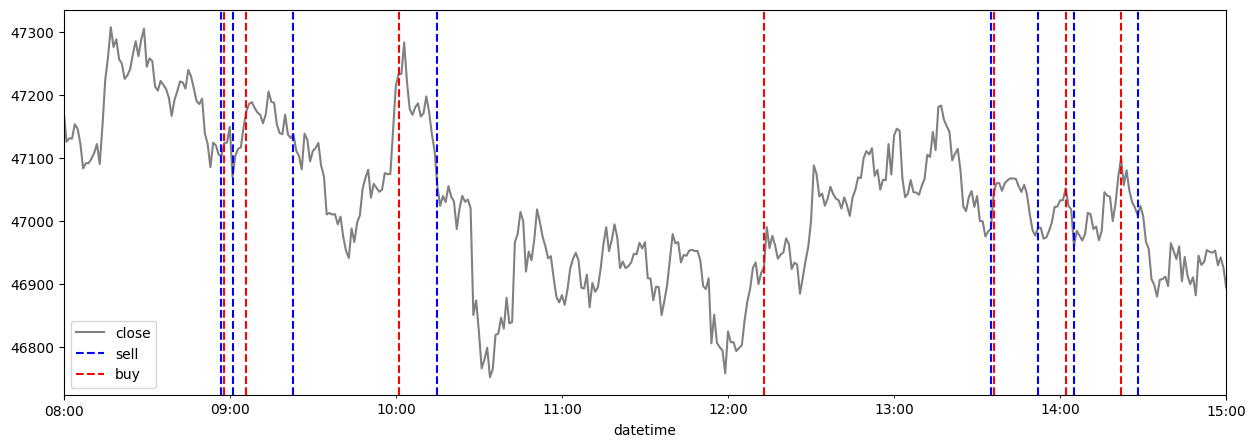

In [224]:

import matplotlib.pyplot as plt

filter_df = t[(t.datetime >= pd.to_datetime('2022-01-01 08:00:00')) & (t.datetime <= pd.to_datetime('2022-01-01 15:00:00'))]

fig,ax = plt.subplots(figsize=(15,5))
filter_df[['datetime','close']].plot(x='datetime',c='gray',ax=ax)
for data in filter_df[filter_df.algorithm != 'stay'][['datetime','algorithm']].values:
    
    time = data[0]
    algorithm = data[1]
    
    if algorithm =='buy':
        ax.axvline(time,color='r',label='buy',linestyle= '--')
        
    else:
        ax.axvline(time,color='b',label='sell',linestyle= '--')
    
ax.legend(ax.get_legend_handles_labels()[0][:3], ax.get_legend_handles_labels()[1][:3])
plt.show()

### 기계학습4
아래의 정의된 컬럼들로 result의 loss와 profit을 예측하는 모델을 만들려고 한다.

- open
- 시작가,종가 가격차이 (open - close)
- algorithm
- t분과 t-5분시점의 close값의 차이

2022년 2월 ~ 12월까지의 데이터를 train,  2023년 1~2월의 데이터를 평가 데이터로 하고 result의 값이 loss,profit인 데이터만 학습에 사용하여     
랜덤포레스트와 서포트 벡터머신 분류모델을 만들고 test데이터에 대해 accuracy를 비교하라. test데이터에 대한 예측 진행시 profit일 확률이 60%이상인 경우에만 profit으로 예측한다

In [239]:
t['del_oc'] =t['open'] - t['close']
t['del_5min'] = t['close'] - t['close'].shift(5)

t = t.dropna().reset_index(drop=True)
model_df = t[['datetime','open','del_oc','del_5min','algorithm','result']]
model_df = model_df[model_df.result.isin(['loss','profit'])]


train = model_df[(model_df.datetime.dt.year ==2022) & ( model_df.datetime.dt.month.isin(range(2,13)))]
test = model_df[(model_df.datetime.dt.year ==2023) & ( model_df.datetime.dt.month.isin(range(1,3)))]

train_x = pd.get_dummies(train.drop(columns =['result','datetime']))
train_y = train['result'].map({'loss':0,'profit':1})

test_x = pd.get_dummies(test.drop(columns =['result','datetime']))
test_y = test['result'].map({'loss':0,'profit':1})


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

rf = RandomForestClassifier(random_state=1)
svc = SVC(probability=True)

rf.fit(train_x,train_y)
rf_predict_proba = rf.predict_proba(test_x)

sc = StandardScaler()
scaled_df = sc.fit_transform(train_x[['open', 'del_oc', 'del_5min']])
scaled_df_concat = pd.concat([pd.DataFrame(scaled_df),train_x[['algorithm_buy','algorithm_sell']].reset_index(drop=True)],axis=1)


svc.fit(scaled_df_concat.values,train_y)

# test_x 변환
scaled_df = sc.transform(test_x[['open', 'del_oc', 'del_5min']])
predict_test_x = pd.concat([pd.DataFrame(scaled_df),test_x[['algorithm_buy','algorithm_sell']].reset_index(drop=True)],axis=1)
svc_predict_proba = svc.predict_proba(predict_test_x.values)

rf_predict_df = pd.DataFrame(rf_predict_proba)
svc_predict_df = pd.DataFrame(svc_predict_proba)


rf_predict_df['label'] =rf_predict_df[1].map(lambda x : 1 if x >=0.6 else 0)
svc_predict_df['label'] =svc_predict_df[1].map(lambda x : 1 if x >=0.6 else 0)

accuracy_score(test_y,rf_predict_df['label']) ,accuracy_score(test_y,svc_predict_df['label'])

### 유저의 카드사용 데이터

데이터 출처 :https://www.kaggle.com/datasets/arjunbhasin2013/ccdata     
dataurl ='./data/user_data.csv'

다음은 Credit Card 데이터셋의 데이터 사전 및 각 컬럼의 한글 번역입니다:

1. **CUST_ID**: 신용카드 보유자 식별

2. **BALANCE**: 계좌에 남아 있는 구매 가능 잔액

3. **BALANCE_FREQUENCY**: 잔액 업데이트 빈도, 0과 1 사이의 점수 (1 = 자주 업데이트됨, 0 = 자주 업데이트되지 않음)

4. **PURCHASES**: 계좌에서의 구매 금액

5. **ONEOFF_PURCHASES**: 한 번에 최대 구매 금액

6. **INSTALLMENTS_PURCHASES**: 할부로 구매한 금액

7. **CASH_ADVANCE**: 사용자가 미리 지급한 현금

8. **PURCHASES_FREQUENCY**: 구매 빈도, 0과 1 사이의 점수 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

9. **ONEOFFPURCHASESFREQUENCY**: 일회성 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

10. **PURCHASESINSTALLMENTSFREQUENCY**: 할부 구매 빈도 (1 = 자주 구매함, 0 = 자주 구매하지 않음)

11. **CASHADVANCEFREQUENCY**: 현금 선지급 빈도 (1 = 자주 선지급함, 0 = 자주 선지급하지 않음)

12. **CASHADVANCETRX**: 현금 선지급으로 이루어진 거래 수

13. **PURCHASES_TRX**: 구매 거래 수

14. **CREDIT_LIMIT**: 사용자 신용카드의 한도

15. **PAYMENTS**: 사용자가 지불한 금액

16. **MINIMUM_PAYMENTS**: 사용자가 지불한 최소 금액

17. **PRCFULLPAYMENT**: 사용자가 지불한 전체 금액의 백분율

18. **TENURE**: 신용카드 서비스 사용 기간

In [283]:
import pandas as pd
df = pd.read_csv('./data/user_data.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 기계학습
데이터 EDA를 실시하고 결측치와 이상치를 처리하라 (시각화 포함)

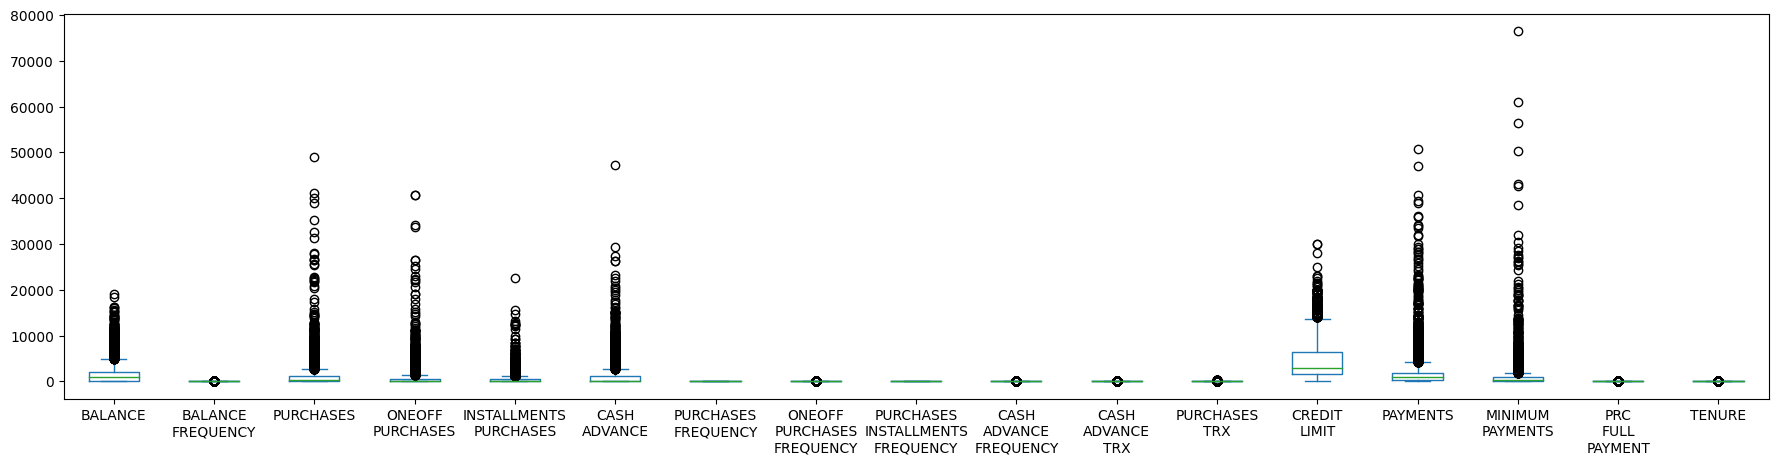

iqr 이상치제거방식으로 MINIMUM_PAYMENTS,ONEOFF_PURCHASES 두개의 컬럼에서 이상치를 제거했다.  


In [313]:
#결측치 제거
df['CREDIT_LIMIT'] =df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())
df['MINIMUM_PAYMENTS'] =df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(22,5))
fig_df = df.copy()
fig_df.columns = [x.replace('_','\n') for x in fig_df.columns]
fig_df.drop(columns =['CUST\nID']).plot(kind='box',ax=ax)
plt.show()


def iqr(df,columns):
    
    q1 = df[columns].quantile(0.25)
    q3 = df[columns].quantile(0.75)

    iqr = q3 -q1
    
    under = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5
    
    filter_df = df[(df[columns] >under) & (df[columns] <upper )]
    return filter_df


df_filter_1 = iqr(df,'MINIMUM_PAYMENTS')
df_filter_2 = iqr(df_filter_1,'ONEOFF_PURCHASES')

print('iqr 이상치제거방식으로 MINIMUM_PAYMENTS,ONEOFF_PURCHASES 두개의 컬럼에서 이상치를 제거했다.  ')

### 기계학습6     
PCA를 통해 적절한 차원으로 데이터를 축소하고 평가하라

In [327]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


sc =StandardScaler()

scaled_df = sc.fit_transform(df_filter_2.drop(columns =['CUST_ID']))

pca = PCA()
pca.fit(scaled_df)
evr = pd.DataFrame(pca.explained_variance_ratio_, columns =['explained_variance_ratio_'])
evr['cumsum'] = evr['explained_variance_ratio_'].cumsum()
display(evr)

print('스케일링 후 pca를 진행한다. 누적분산설명력이 0.85이상인 8개의 컬럼으로 차원축소를 선택한다.')

pca = PCA(n_components=8)
pca.fit(scaled_df)
pca_df = pd.DataFrame(pca.transform(scaled_df))


,explained_variance_ratio_,cumsum
0,0.268046,0.268046
1,0.199934,0.467980
2,0.093258,0.561238
3,0.081271,0.642509
4,0.073212,0.715720
5,0.053061,0.768781
6,0.049065,0.817846
7,0.041297,0.859143
8,0.036698,0.895841
9,0.031445,0.927286


스케일링 후 pca를 진행한다. 누적분산설명력이 0.85이상인 8개의 컬럼으로 차원축소를 선택한다.


### 기계학습7     
위의 차원 축소된 데이터를 바탕으로 KMeans 클러스터링을 실시하라.     
응집도와 분리도를 기반으로 적절 클러스터 숫자를 구하고 두개의 주성분 차원에 군집 중심을 포함하여 시각화하라

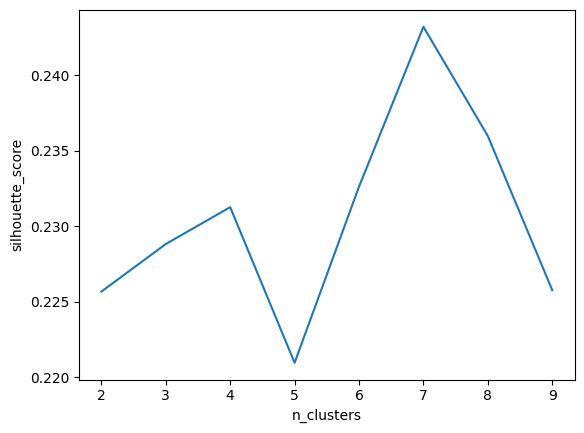

In [332]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


lst = []

for n_clusters in range(2,10):
    km = KMeans(n_clusters=n_clusters , random_state=123 ,n_init =10)
    km.fit(pca_df)
    
    km_predict = km.predict(pca_df)
    
    ss = silhouette_score(pca_df,km_predict)
    lst.append(ss)
    

plt.plot(range(2,10),lst)
plt.xlabel('n_clusters')
plt.ylabel('silhouette_score')
plt.show()
    



In [333]:
km =KMeans(n_clusters=7 , random_state=123 ,n_init =10)
km.fit(pca_df)

predict_label = km.predict(pca_df)

In [341]:
km.cluster_centers_.shape

(7, 8)

In [339]:
pca_df.shape

(7258, 8)

In [342]:
import seaborn as sns

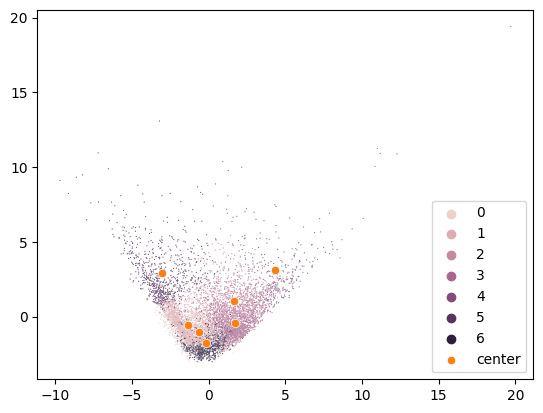

In [353]:
sns.scatterplot(x = pca_df.values[:,0],y= pca_df.values[:,1],hue =predict_label ,s=0.7)
sns.scatterplot(x = km.cluster_centers_[:,0],y =km.cluster_centers_[:,1],label='center')
plt.show()

### 기계학습8   
마케팅 담당자인 당신은 KMeans 군집 결과를 통해 각 군집 특성을 파악하고 군집별 프로모션 전략을 서술하라
    

In [357]:
df_filter_result = df_filter_2.copy().reset_index(drop=True)
df_filter_result['label'] = predict_label

In [362]:
result = df_filter_result.drop(columns =['CUST_ID']).groupby(['label']).mean().T.round(1)
result.loc[['BALANCE','PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE'],]

label,0,1,2,3,4,5,6
BALANCE,674.1,1347.8,1094.8,471.3,1345.5,3686.2,92.9
PURCHASES,262.6,119.4,1042.4,630.9,2642.8,245.6,244.5
INSTALLMENTS_PURCHASES,126.4,38.4,230.6,570.5,1982.6,113.5,112.9
CASH_ADVANCE,964.2,717.4,286.2,130.8,420.8,4322.2,288.6


BALANCE: 계좌에 남아 있는 구매 가능 잔액    
PURCHASES: 계좌에서의 구매 금액    
INSTALLMENTS_PURCHASES: 할부로 구매한 금액   
CASH_ADVANCE: 사용자가 미리 지급한 현금    


군집별 컬럼 평균 값을 구하고 군집간 차이가 큰 컬럼 4개를 선정했다.      
군집간 차이를 통해 각 군집의 특성을 파악하고 그에 맞는 프로모션 전략을 취한다.

### 기계학습9
병합적 계층군집을 실시하고 덴드로그램을 시각화하라. 군집간 거리는 ward 방식으로 업데이트하며 위 문제에서 구한 최적 군집 갯수가 만들어지 지기 위한 거리 범위를 구하라

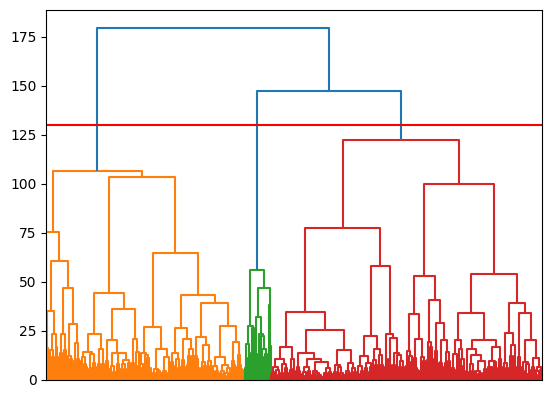

In [381]:
from scipy.cluster.hierarchy import dendrogram,linkage


lk = linkage(pca_df,'ward')
d = dendrogram(lk)
plt.xticks([])
plt.axhline(130,c='r')
plt.show()

In [376]:
import numpy as np

In [385]:
thr = pd.DataFrame(np.array(d['dcoord']))
thr[thr[2] >70].sort_values(2)[[2]]

,2
513,75.318693
5256,77.500553
7253,99.872042
2911,103.515680
2912,106.544534
7254,122.349494
7255,147.333962
7256,179.616031


첫 번째 값 (dcoord[i][0]): 선분의 시작 지점의 y좌표.     
두 번째 값 (dcoord[i][1]): 선분의 중간 지점의 y좌표 (시작 지점에서 수평으로 이동한 지점).    
세 번째 값 (dcoord[i][2]): 선분의 중간 지점의 y좌표 (중간에서 수평으로 이동한 지점).    
네 번째 값 (dcoord[i][3]): 선분의 끝 지점의 y좌표.     

77.500553보다는 크고 99.872042보다는 작아야한다

# 통계 (40점)

### 통계1      
어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률을 구하라.

In [388]:
from scipy.stats import hypergeom


rv = hypergeom(43,11,8)
result =1 - rv.pmf(0) - rv.pmf(1)
result

0.6721384488647233

### 통계2
data_path = ./data/stats_reg1.csv     
종속변수 : Target   
독립변수 : 다양한 센서데이터

In [390]:
import pandas as pd
df =pd.read_csv('./data/stats_reg1.csv')
df.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,Target
0,0.296120,-1.463515,-0.327662,0.005113,-0.702053,0.097078,-0.392108,0.261055,0.968645,2,3,1.475520,-0.363724,-0.503583,-1.464364,7.709164
1,1.579213,-0.234137,1.523030,-0.469474,0.647689,0.496714,-0.234153,0.767435,-0.138264,2,1,0.387250,0.907459,0.928492,0.938609,264.129513
2,-0.562467,0.707752,-0.626967,0.972554,1.770801,-0.703176,1.812449,0.632408,-0.034988,2,2,0.955285,-0.096463,-0.030130,2.166524,211.602064
3,1.496044,-1.778720,-0.773789,-0.055585,1.876796,1.355638,-1.244655,0.654366,0.413435,2,1,0.441394,0.352448,-0.467829,2.433214,273.654357
4,-0.759133,-0.525755,-0.599393,0.341756,-0.839722,2.189803,-2.123896,0.150394,-0.808298,1,2,0.991974,-0.562178,-0.176573,-0.068282,-158.208708


### 통계2-1
변수들의 다중공선성을 검토하라


In [402]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

dff = df.drop(columns =['Target'])
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(dff.values,i) for i in range(dff.shape[1])]
vif['feature'] = dff.columns

display(vif)

print('F_1,F_2,F_11,F_12,F_13 높은 VIF값을 가진다')

,VIF Factor,feature
0,44.238222,F_1
1,14.524559,F_2
2,2.101471,F_3
3,1.859888,F_4
4,2.195660,F_5
5,1.142734,F_6
6,1.200195,F_7
7,1.089550,F_8
8,1.190482,F_9
9,5.828291,F_10


F_1,F_2,F_11,F_12,F_13 높은 VIF값을 가진다


### 통계2-2
다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용하라


In [404]:
# pca - 차원축소를 통해 변수간 상관성을 줄인다.
# 변수제거 - 상관관계가 높은 변수들중 일부를 제거하여 다중공선선을 해결한다.



In [423]:
# 변수간 상관관계 추출 후 상관계수로 정렬
cor = dff.corr().unstack().reset_index()
cor.columns =['col1','col2','Corr']
cor_filter = cor[cor.Corr != 1].sort_values('Corr')[::2].reset_index(drop=True)
cor_filter

,col1,col2,Corr
0,F_9,F_2,-0.333773
1,F_2,F_1,-0.257508
2,F_7,F_4,-0.254480
3,F_6,F_5,-0.151907
4,F_8,F_11,-0.135043
5,F_10,F_9,-0.127197
6,F_6,F_11,-0.123116
7,F_12,F_8,-0.118404
8,F_12,F_4,-0.110991
9,F_9,F_12,-0.105393


In [427]:
df_remove = df.drop(columns =['F_11','F_1'])

dff = df_remove.drop(columns =['Target'])
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(dff.values,i) for i in range(dff.shape[1])]
vif['feature'] = dff.columns

display(vif)

print('상관관계가 높은 두 컬럼 중 하나의 컬럼을 임의로 지웠을 때 VIF값이 개선된 것을 확인했다.')

,VIF Factor,feature
0,1.270203,F_2
1,1.975258,F_3
2,1.774063,F_4
3,2.181707,F_5
4,1.089507,F_6
5,1.165103,F_7
6,1.082959,F_8
7,1.173637,F_9
8,5.711413,F_10
9,5.718716,F_12


상관관계가 높은 두 컬럼 중 하나의 컬럼을 임의로 지웠을 때 VIF값이 개선된 것을 확인했다.


### 통계2-3
2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교하라


In [428]:
import statsmodels.api as sm

In [429]:
bef_df = df.drop(columns =['Target'])
aft_df = df.drop(columns =['Target','F_1','F_11'])


X = sm.add_constant(bef_df)
model_pre = sm.OLS(df['Target'],X).fit()

X2 = sm.add_constant(aft_df)

model_aft = sm.OLS(df['Target'],X2).fit()

In [448]:
model_pre.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0314,0.039,0.814,0.418,-0.045,0.108
F_1,61.6675,0.064,957.009,0.000,61.539,61.796
F_2,28.6933,0.035,825.633,0.000,28.624,28.762
F_3,50.7597,0.015,3371.303,0.000,50.730,50.790
F_4,63.1688,0.013,5010.118,0.000,63.144,63.194
F_5,83.1993,0.012,7090.507,0.000,83.176,83.223
F_6,16.0561,0.011,1471.039,0.000,16.034,16.078
F_7,0.6330,0.010,65.170,0.000,0.614,0.652
F_8,98.1078,0.010,9903.423,0.000,98.088,98.127
F_9,81.7976,0.009,8905.585,0.000,81.779,81.816


In [449]:
model_aft.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-7.6310,3.880,-1.967,0.052,-15.345,0.083
F_2,-2.9050,1.060,-2.741,0.007,-5.012,-0.798
F_3,54.6846,1.510,36.211,0.000,51.683,57.687
F_4,65.0076,1.283,50.662,0.000,62.457,67.558
F_5,83.3989,1.218,68.475,0.000,80.978,85.820
F_6,18.2287,1.102,16.536,0.000,16.037,20.420
F_7,-1.0693,0.995,-1.074,0.286,-3.048,0.909
F_8,97.8055,1.029,95.055,0.000,95.760,99.851
F_9,81.0763,0.953,85.041,0.000,79.181,82.972
F_10,2.9382,1.346,2.184,0.032,0.263,5.613


### 통계 3     
data_path = ./data/learn.csv
- 어느 학급의 학생들이 3가지(Lecture,Online,Blended)방식으로 학습하고 시험을 본 결과이다.


In [453]:
import pandas as pd
df = pd.read_csv('./data/learn.csv')
df.head()

,Student,Lecture,Online,Blended
0,1,8.7,67.8,74.2
1,2,18.2,97.2,76.5
2,3,7.5,74.8,69.1
3,4,39.7,62.3,68.4
4,5,73.4,84.9,84.5


### 통계 3-1
3가지 방식 각각 점수 분포가 정규성을 만족하는지와 방식들간의 분산은 동일한지 검정하라

In [457]:
from scipy.stats import shapiro , levene

lc = df['Lecture']
on = df['Online']
bl = df['Blended']


s,p_lec = shapiro(lc)
s,p_on = shapiro(on)
s,p_bl = shapiro(bl)
s,p = levene(lc,on,bl)

print(f'''
샤피로 검정시 Lecture ,Online,Blended 방식의 각각의 pvalue값은 {p_lec},{p_on},{p_bl}이다.
샤피로 검정은 귀무가설이 정규성을 만족한다이다. 즉 lecture방식만 유의수준 0.05하에 대립가설을 채택하며 정규성을 만족하지 않는다. 그 외 방식은 모두 정규성을 만족한다.
levene 검정을 통해 각 컬럼들이 등분산을 만족하는지 확인해보면 pvalue는 {p}로 나온다. levene검정의 귀무가설은 등분산을 만족한다이다. 즉 3컬럼 중 적어도 하나의 컬럼이 
등분산을 위배한다.
''')


샤피로 검정시 Lecture ,Online,Blended 방식의 각각의 pvalue값은 0.004649947863072157,0.9098509550094604,0.3639613687992096이다.
샤피로 검정은 귀무가설이 정규성을 만족한다이다. 즉 lecture방식만 유의수준 0.05하에 대립가설을 채택하며 정규성을 만족하지 않는다. 그 외 방식은 모두 정규성을 만족한다.
levene 검정을 통해 각 컬럼들이 등분산을 만족하는지 확인해보면 pvalue는 5.894135513581264e-05로 나온다. levene검정의 귀무가설은 등분산을 만족한다이다. 즉 3컬럼 중 적어도 하나의 컬럼이 
등분산을 위배한다.



### 통계 3-2
위 결과에 맞는 그룹간 점수 분포 차이가 존재하는지를 확인하는 통계 검정 전략을 설명하라

비모수 프리드먼

### 통계 3-3
가설에 따른 검정을 수행하고, 검정통계량과 p-value를 설명하라

In [458]:
from scipy.stats import friedmanchisquare

s,p = friedmanchisquare(df['Lecture'],df['Online'],df['Blended'])
print(f'''
프리드먼 검정의 귀무가설은 '3가지 방법 간에 차이가 없다'이며 대립가설은 적어도 하나의 방식에서 차이가 있다 이다.
검정결과 pvalue는 {p}로 귀무가설을 기각한다. 즉 적어도 하나의 방식에는 차이가 존재하며 사후 분석을 통해 어떤 그룹에서 차이가 존재하는지 살펴볼 여지가 있다
''')


프리드먼 검정의 귀무가설은 3가지 방법 간에 차이가 없다이며 대립가설은 적어도 하나의 방식애서 차이가 있다 이다.
검정결과 pvalue는 4.575338769445776e-08로 귀무가설을 기각한다. 즉 적어도 하나의 방식에는 차이가 존재하며 사후 분석을 통해 어떤 그룹에서 차이가 존재하는지 살펴볼 여지가 있다

